In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import Plot as plot
import math
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
import time
import datetime
import pickle
import os
import scipy.spatial
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as plt
import logging
from scipy import signal
import learningAlgs as classImportLA
import dataManipulation as dataMan
from itertools import permutations
import importlib
from datetime import timedelta
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import KMeans
import timeIntervalPlotter as intervalPlotter
import pysal
import warnings
import lumping_traditional as oldLumping
import boundaryFull_SS_WeightedLumping as WLumping
from importlib import reload
from scipy.stats import rayleigh
import dataManipulation as dataMan
import matplotlib.pyplot as plt
import processData as processData
import tensorflow as tf
# import tensorflow_probability as tfp
import random
from random import shuffle

warnings.filterwarnings('always')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fetching Feature Engineered Data

In [3]:
data = pd.read_pickle("5minMerged_featureEngineer.pickle")

# Preparing Data for Training and Testing

In [5]:
def classifying(CU, boundaries):
    occupiedBandwidth = (CU / 255) * 100
    for i in range(len(boundaries)):
        if occupiedBandwidth <= boundaries[i]:
            return i

In [15]:
def dataPreparation(data, timeIndexes, minuteSplit, boundaries):
    from sklearn.utils import shuffle
    warnings.filterwarnings('always')
    reg = "l2"
    solvers = "lbfgs"
    clf = LogisticRegression(penalty = reg, max_iter = 100000, random_state = 0,
                             solver = solvers , multi_class = 'multinomial')
    accuracyValue = 0
    numOfElements = 0
    f1scoreValue = 0
    precisionValue = 0
    recallValue = 0
    prevRowTrain = np.inf
    prevCU = np.inf

    sampleIntervals = 6 #seconds
    minuteSplit = 30 #minutes
    numOfSamples = minuteSplit * 60 / sampleIntervals
    # numberOfDays = len(numOfDays)
    days = np.zeros(7)
    numOfThirtyMinsPerDay = np.zeros(int((24 * 60) / minuteSplit)) #in this case 48
#     which6SecondsPerPeriod = np.zeros(int(minuteSplit * 60 / sampleIntervals)) #in this case 300
    prevRowTrain = np.inf
    prevCU = np.inf

    XArraysForLearning = []
    YArraysForLearning = []
    XArraysForTesting = []
    YArraysForTesting = []

    x = timeIndexes
    wholeDataFrame = data.loc[(data["timeIndex"] == x)].copy()
    
    wholeDataFrame["cuClass"] = wholeDataFrame["CU"].apply(lambda x: classifying(x, boundaries))

    

    stackCounter = 0
    prevCU = 0
    prev2CU = 0
    prev3CU = 0
    prev4CU = 0
    prev5CU = 0
    print("start training set generation")
    #number of features are: prevCU + 48 correlations + 1 logDiff
    numberOfFeatures = len(boundaries) + 12 + 1 
    
    XArraysForLearning = np.zeros(shape=(len(wholeDataFrame), numberOfFeatures))
    YArraysForLearning = np.zeros(shape=(len(wholeDataFrame), len(boundaries)))
#     print(len(trainingDataFrame))
    counter = 0
    pandasIndexCounter = 0
    for index, row in wholeDataFrame.iterrows():
        XArraysForLearning[pandasIndexCounter, prevCU] = 1
        for corrs in range(11):
            XArraysForLearning[pandasIndexCounter, len(boundaries) + corrs] = row["corr" + str(corrs + 1)]

        XArraysForLearning[pandasIndexCounter, len(boundaries) + 12] = row["normalLogDiff"]
        YArraysForLearning[pandasIndexCounter, row["cuClass"]] = 1
#         print(XArraysForLearning[pandasIndexCounter])

        which6SecondsPerPeriod = 0
    
        prevCU = row["cuClass"]
        pandasIndexCounter += 1

    XArraysForLearning, YArraysForLearning = shuffle(XArraysForLearning, YArraysForLearning, random_state=0)
    XArraysForTraining = XArraysForLearning[:int(0.8*len(XArraysForLearning))]
    YArraysForTraining = YArraysForLearning[:int(0.8*len(YArraysForLearning))]
    XArraysForTesting = XArraysForLearning[int(0.8*len(XArraysForLearning)):]
    YArraysForTesting = YArraysForLearning[int(0.8*len(YArraysForLearning)):]
    print(XArraysForTraining.shape[0])
    print(XArraysForTesting.shape[0])


    return XArraysForTraining, YArraysForTraining, XArraysForTesting, YArraysForTesting, boundaries


# TensorFlow Function Running

In [104]:
def tensorFlowLossFunction(
    lossFuncBool, XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries):
    
    batch_size = 64
    learning_rate = 0.01
    beta = 0.1
    numOfEpochs = 5000
    graph = tf.Graph()
    with graph.as_default():
        x = tf.placeholder(tf.float32, shape = (batch_size, XArraysForLearning.shape[1]))
        y_ = tf.placeholder(tf.float32, shape = (batch_size, YArraysForLearning.shape[1]))
#         print(weights.dtype)
#         print(weights.shape)
#         print(XArraysForLearning.shape[1], YArraysForLearning.shape[1])
#         multiDistrib = np.vstack((mult, mult))
#         for i in range(batch_size - 2):
#             multiDistrib = np.vstack((multiDistrib, mult))
        W = tf.Variable(tf.truncated_normal([XArraysForLearning.shape[1], YArraysForLearning.shape[1]], seed = 0), name="weights", dtype=tf.float32)
        b = tf.Variable(tf.truncated_normal([YArraysForLearning.shape[1]], seed = 0), dtype=tf.float32)

        tf_test_dataset64 = tf.constant(XArraysForTesting)
        tf_test_dataset = tf.cast(tf_test_dataset64, tf.float32)


        beta = 0.05
        logits = tf.matmul(x, W)
        train_prediction = tf.nn.softmax(logits)
        # train_prediction = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_, logits = logits)
        test_prediction = tf.nn.softmax(tf.add(tf.matmul(tf_test_dataset, W),b))

        # x = XArraysForLearning[0:(0 + batch_size), :]
        # y_ = tf.Variable(YArraysForLearning[0:(0 + batch_size), :])

        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        # loss = assymetricLossFunction(train_prediction, y_, boundaries)
        
        if lossFuncBool == 0:
            loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = y_)
        
        elif lossFuncBool == 1:
            loss = assymetricLossFunction(train_prediction, y_, boundaries)
#         dist = tfp.distributions.Multinomial(total_count=1, logits=logits)
#         loss = loss - (dist.log_prob(mult))
        # regularizer = tf.nn.l2_loss(W)
        # loss = tf.reduce_mean(loss + beta * regularizer)
        # loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = train_prediction, labels = y_)
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        prevAcc = 0
        prevLoss = np.inf

    with tf.Session(graph=graph) as session:
        initializer = tf.contrib.layers.xavier_initializer()
        tf.set_random_seed(0)
        W = tf.Variable(initializer([XArraysForLearning.shape[1], YArraysForLearning.shape[1]]))
        b = tf.Variable(initializer([YArraysForLearning.shape[1]]))       
        tf.global_variables_initializer().run()
#         print(W.eval())
        
        print("Initialized")

        numberOfBatchIteration = int(XArraysForLearning.shape[0] / batch_size)
        restOfData = XArraysForLearning.shape[0] % batch_size
        if restOfData != 0:
            numberOfBatchIteration += 1

        accuracy_result = 0
        accuracy_earlyStop = 0
        earlyStoppingCounter = 0
        
        for epoch in range(numOfEpochs):
            accuracyValue = 0
            lossValue = 0
            totalBatch = 0
            i = 0
            randomize = np.arange(XArraysForLearning.shape[0])
            random.Random(epoch).shuffle(randomize)
            XArraysForLearning = XArraysForLearning[randomize]
            YArraysForLearning = YArraysForLearning[randomize]

            for iteration in range(numberOfBatchIteration):
                if (iteration == numberOfBatchIteration - 1) and restOfData != 0:
                    break
                    batch_data = XArraysForLearning[i:, :]
                    batch_labels = YArraysForLearning[i:, :]

                else:
                    batch_data = XArraysForLearning[i:(i + batch_size), :]
                    batch_labels = YArraysForLearning[i:(i + batch_size), :]

                    i += batch_size


                feed_dict = {x : batch_data, y_ : batch_labels}
                _, predictions, l = session.run([optimizer, train_prediction, loss], feed_dict=feed_dict)

#                 print(l)
                lossValue *= (iteration)
                lossValue += (np.sum(l))
                lossValue /= (iteration + 1)
                totalBatch += batch_size
                # print(accuracy(batch_data, batch_labels))
                
                accuracyValue += accuracy(predictions, batch_labels) * batch_size


            totalAccuracy = accuracyValue/totalBatch
#             print(session.run(W))
#             test_result = test_prediction.eval()
            if epoch % 20 == 0:
                print("epoch ", epoch, totalAccuracy, lossValue)
                
            if lossValue > prevLoss and earlyStoppingCounter == 50:
                break

            elif lossValue > prevLoss:
                earlyStoppingCounter += 1

            elif lossValue <= prevLoss:
                prevLoss = lossValue
                earlyStoppingCounter = 0
#             print(accuracy(test_result, YArraysForTesting), prevAcc, earlyStoppingCounter)
                
            



        # print(session.run(W))
        predictionResult = test_prediction.eval()
        accResult = accuracy(predictionResult , YArraysForTesting)
        penaltyValue = assymetricPredictionScore(predictionResult, YArraysForTesting, boundaries)

        accuracy_result = accResult
            
        correctLableIndex = np.argmax(YArraysForTesting, 1)
        predictionIndex = np.argmax(predictionResult, 1)
        
        precision = precision_score(correctLableIndex, predictionIndex, average='weighted')
        recall = recall_score(correctLableIndex, predictionIndex, average='weighted')
        f1Score = f1_score(correctLableIndex, predictionIndex, average='weighted')            
        
        return accuracy_result, penaltyValue, precision, recall, f1Score
            
    
def assymetricPredictionScore(predictedLables, trueLables, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338

    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    minState = np.argmin(inverseDistrib)

    underUtilizedSum = 0
    overUtilizedSum = 0
    numberOfUnderUtilizedStates = minState - 0
    numberOfOverUtilizedStates = maxState - minState

    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100

    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)

    diffPercentage = np.zeros(shape = (predictedLables.shape))

    penalties = np.zeros(shape = (predictedLables.shape))

    for index in range(predictedLables.shape[0]):
        diffPercentage[index] = boundaries[correctLableIndex[index]] - boundaries[:]


    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            if diffPercentage[i][j] > 0:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * overUtilVal)]
            else:
                penalties[i][j] = inverseDistrib[minState + math.floor
                                                  (diffPercentage[i][j] * underUtilVal)]

    sumOfPenalty = 0
    for i in range(predictionIndex.shape[0]):
        penalties[i] = penalties[i] / np.sum(penalties[i])
        sumOfPenalty += penalties[i][predictionIndex[i]]

    return sumOfPenalty
    
    
def accuracy(predictedLables, trueLables):
    import sys
    np.set_printoptions(threshold=sys.maxsize)
    correctLableIndex = np.argmax(trueLables, 1)
    predictionIndex = np.argmax(predictedLables, 1)
    errors = [0 for i in range(trueLables.shape[1])]
    corrects = [0 for i in range(trueLables.shape[1])]
    for i in range(len(correctLableIndex)):
        if correctLableIndex[i] != predictionIndex[i]:
            errors[correctLableIndex[i]] += 1
            corrects[predictionIndex[i]] += 1

    acc = np.float64(np.sum(correctLableIndex == predictionIndex)/predictedLables.shape[0])
    return acc
    
    
def assymetricLossFunction(prediction, correctLable, boundaries):
    xAxisPoints = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 338)
    #number of overal datapoints must stay the same all the time
    maxState = 338
    inverseDistrib = max(rayleigh.pdf(xAxisPoints)) - rayleigh.pdf(xAxisPoints)
    inverseDistrib = tf.constant(inverseDistrib)
    xAxisPoints -= xAxisPoints[np.argmin(inverseDistrib)]
    minState = np.argmin(inverseDistrib)
    numberOfOverUtilizedStates = maxState - minState
    numberOfUnderUtilizedStates = minState
    minState = tf.constant(minState, tf.float32)
    numberOfOverUtilizedStates = tf.constant(numberOfOverUtilizedStates, tf.float32)
    numberOfUnderUtilizedStates = tf.constant(numberOfUnderUtilizedStates, tf.float32)

    underUtilVal = numberOfUnderUtilizedStates / 100
    overUtilVal = numberOfOverUtilizedStates / 100


    boundaries = tf.constant(boundaries, tf.float32)
    correctLableIndex = tf.argmax(correctLable, 1)

    diffPercentage = []
    for index in range(correctLableIndex.shape[0]):
        diffPercentage.append(boundaries[correctLableIndex[index]] - boundaries[:])

    diffPercentage = tf.stack(diffPercentage)

    penalties = []

    counter = 0
    for i in range(diffPercentage.shape[0]):
        for j in range(diffPercentage.shape[1]):
            counter += 1

            penalties.append(tf.cond(
                    tf.greater(diffPercentage[i][j], 0),
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul(diffPercentage[i][j],
                                                                                       overUtilVal)), tf.int32)],
                    lambda: inverseDistrib[tf.dtypes.cast(minState + tf.math.floor
                                                                   (tf.math.scalar_mul
                                                                    (diffPercentage[i][j], underUtilVal))
                                                                   , tf.int32)]
                    ))

    penalties = tf.stack(penalties)
    penalties = tf.dtypes.cast(penalties, tf.float32)
    penalties = tf.reshape(penalties, diffPercentage.shape)
    penalties = penalties / tf.norm(penalties)

    # weights = tf.reduce_sum(penalties * (1-prediction), axis=1)
    weights = (1 - penalties) * prediction
    weights = weights / tf.norm(weights)
    # print(correctLable)
    # print(prediction)
    # print(penalties)
    loss = tf.losses.softmax_cross_entropy(onehot_labels = correctLable, logits = weights)
    # weighted_losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels = penalties, logits = prediction)
    # loss = tf.reduce_sum(weighted_losses)
    # loss = tf.reduce_sum(penalties * prediction)
    return tf.reduce_mean(loss)

# Fetching Lumped Matrices with their Bandwidths - 25 cons

## 6 Classes

In [146]:
name = "/home/sepehr/thesis/APDataML/5normal_correlated_lumping_Boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [9]:
normalLumping[0]

[(1.0,
  40.3974609375,
  array([[0.81138113, 0.        , 0.        , 0.        , 0.        ,
          0.        ],
         [0.42046432, 0.25824308, 0.01708785, 0.0010661 , 0.        ,
          0.        ],
         [0.32352941, 0.2735426 , 0.21568627, 0.00939597, 0.        ,
          0.        ],
         [0.23076923, 0.        , 0.        , 0.15384615, 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.2       ,
          0.2       ]]),
  [-1, 20, 35, 48, 72, 84, 89])]

In [147]:
percentageArray = []
for i in range(12):
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_correlated_lumping_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [116]:
accuracyResult = [np.inf for i in range(12)]
penaltyResult = [np.inf for i in range(12)]
precisionResult = [np.inf for i in range(12)]
recallResult = [np.inf for i in range(12)]
f1ScoreResult = [np.inf for i in range(12)]
boundariesResult = [np.inf for i in range(12)]
lumpAproxResult = [np.inf for i in range(12)]
lumpErrorResult = [np.inf for i in range(12)]
wieghts = [np.inf for i in range(12)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult, "wieghts": wieghts}


resultDataFrameNoPenalty_7Class = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty_7Class = resultDataFrameNoPenalty.astype('object')

In [121]:
normalLumping[11][0][3]

[-1, 7, 30, 47, 58, 82, 89]

In [150]:
warnings.filterwarnings('ignore')
for timeIndex in range(12):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty_7Class.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 24.31372549  39.21568627  52.15686275  76.07843137  88.23529412
 100.        ]
start training set generation
375309
93828
starting tensor
Initialized
epoch  0 0.9463090467257844 9.92492367185926
epoch  20 0.952618732946794 7.8199438000501935
epoch  40 0.9524615237039563 7.792892735304075
epoch  60 0.952437542633015 7.785266905840064
epoch  80 0.952512150409277 7.777019464455311
epoch  100 0.952584093622101 7.778328515294467
epoch  120 0.9527093281036835 7.781479043898771
epoch  140 0.952618732946794 7.771284366511876
epoch  160 0.9526587013983628 7.7719362292332015
epoch  180 0.9526240620736699 7.7628231201051525
epoch  200 0.9526347203274216 7.770070522545875
epoch  220 0.9527333091746248 7.768668807270501
epoch  240 0.9527119926671214 7.761634443438071
epoch  260 0.9527466319918144 7.765193527404316


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



1
[ 10.19607843  33.33333333  52.15686275  62.35294118  75.29411765
 100.        ]
start training set generation
27545
6887
starting tensor
Initialized
epoch  0 0.8129360465116279 38.68592453224714
epoch  20 0.9226380813953489 12.192730143458341
epoch  40 0.923546511627907 11.92885635398155
epoch  60 0.9237281976744186 11.845017505246535
epoch  80 0.9241279069767442 11.78131572534872
epoch  100 0.9239462209302326 11.787825511777127
epoch  120 0.9239462209302326 11.755172112930644
epoch  140 0.9235828488372093 11.735437810698222
epoch  160 0.9250363372093023 11.678866640911542
epoch  180 0.9247456395348838 11.706495438620104
epoch  200 0.924672965116279 11.693364967301832
epoch  220 0.925 11.68083695450494
epoch  240 0.9247456395348838 11.667669682724535
epoch  260 0.9247093023255814 11.639229850990832
epoch  280 0.9250363372093023 11.675907620163851
epoch  300 0.9258357558139535 11.655229730938764
epoch  320 0.9247456395348838 11.655726057429646
epoch  340 0.924672965116279 11.65046580

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[ 11.37254902  36.07843137  52.15686275  63.1372549   81.17647059
 100.        ]
start training set generation
24492
6123
starting tensor
Initialized
epoch  0 0.8044420811518325 42.340478218038655
epoch  20 0.9278877617801047 11.7636507375078
epoch  40 0.9280104712041884 11.524075028159855
epoch  60 0.9288694371727748 11.440312482923737
epoch  80 0.9296875 11.335281536841263
epoch  100 0.9296465968586387 11.349406358459232
epoch  120 0.9302601439790575 11.326078480450892
epoch  140 0.9301374345549738 11.272553336557909
epoch  160 0.9298102094240838 11.32662334117589
epoch  180 0.9303419502617801 11.245735644045928
epoch  200 0.9305464659685864 11.24411279243948
epoch  220 0.9299329188481675 11.237637331972573
epoch  240 0.9300965314136126 11.246470249136086
epoch  260 0.9302601439790575 11.226730223101479
epoch  280 0.9304646596858639 11.265665229078358
epoch  300 0.9302601439790575 11.206517146519973
epoch  320 0.9307100785340314 11.220947616387413
epoch  340 0.9309964005235603 11.2

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



3
[ 13.33333333  38.03921569  62.35294118  78.03921569  88.23529412
 100.        ]
start training set generation
52704
13177
starting tensor
Initialized
epoch  0 0.842060297691373 31.46055844053172
epoch  20 0.9136732989064399 13.495029938467223
epoch  40 0.9143377885783718 13.45586889974981
epoch  60 0.9138441676792224 13.40994791619543
epoch  80 0.9141289489671932 13.397855357150405
epoch  100 0.9143567739975699 13.377783940745157
epoch  120 0.9144896719319563 13.392796636351983
epoch  140 0.9145466281895505 13.369022365908426
epoch  160 0.914755467800729 13.383429124027964
epoch  180 0.9140909781287971 13.37375062638905
epoch  200 0.914375759416768 13.387525594393804


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



4
[ 11.37254902  36.07843137  55.29411765  67.05882353  84.31372549
 100.        ]
start training set generation
57952
14489
starting tensor
Initialized
epoch  0 0.839157458563536 33.02190446063297
epoch  20 0.905835635359116 15.168613117175866
epoch  40 0.906975138121547 14.995717491234204
epoch  60 0.9071132596685083 14.971785065877503
epoch  80 0.9070614640883978 14.954704939594585
epoch  100 0.9061636740331491 14.953813957509414
epoch  120 0.9072168508287293 14.937382934106648
epoch  140 0.9074240331491713 14.940933766022571
epoch  160 0.9072341160220995 14.929502833877482
epoch  180 0.9071477900552486 14.930768706390213
epoch  200 0.9067679558011049 14.91194899227079
epoch  220 0.9073549723756906 14.922750532561244
epoch  240 0.9078038674033149 14.91249037078731
epoch  260 0.9076139502762431 14.906197464927125
epoch  280 0.9073031767955801 14.896090244588272
epoch  300 0.9071132596685083 14.90035833021554
epoch  320 0.9072686464088398 14.926402934480109
5
[ 15.29411765  39.2156862

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



6
[ 13.33333333  38.03921569  61.17647059  71.37254902  87.05882353
 100.        ]
start training set generation
22642
5661
starting tensor
Initialized
epoch  0 0.7093661473087819 54.968383735029974
epoch  20 0.8666342067988668 20.196999136516812
epoch  40 0.8678293201133145 19.724737251108834
epoch  60 0.8688473796033994 19.602766839370503
epoch  80 0.8712818696883853 19.51283308737
epoch  100 0.8694670679886686 19.534599468998454
epoch  120 0.8703523371104815 19.477834955491037
epoch  140 0.8700867563739377 19.44440824384392
epoch  160 0.8702638101983002 19.388678964069125
epoch  180 0.8703966005665722 19.430100255917555
epoch  200 0.8719900849858357 19.396030020781367
epoch  220 0.8718130311614731 19.35321346963768
epoch  240 0.8704408640226629 19.406558223216464
epoch  260 0.8711048158640227 19.41364102998469
epoch  280 0.8704851274787535 19.397853670309367
epoch  300 0.8713703966005666 19.372390925377672
epoch  320 0.8714146600566572 19.340424434996855
epoch  340 0.871370396600566

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



7
[ 11.37254902  36.07843137  47.05882353  71.37254902  89.01960784
 100.        ]
start training set generation
6423
1606
starting tensor
Initialized
epoch  0 0.50640625 102.07041225433349
epoch  20 0.85859375 22.465354251861573
epoch  40 0.87140625 20.27660658836364
epoch  60 0.87390625 19.457507944107064
epoch  80 0.8771875 19.005449743270866
epoch  100 0.87921875 18.679496450424192
epoch  120 0.87796875 18.51891961097718
epoch  140 0.880625 18.398663692474376
epoch  160 0.87953125 18.33002751350403
epoch  180 0.88140625 18.211365137100216
epoch  200 0.8790625 18.289298839569092
epoch  220 0.88203125 18.164178543090813
epoch  240 0.8834375 18.154531488418584
epoch  260 0.88390625 18.068132638931278
epoch  280 0.88359375 18.056089024543763
epoch  300 0.88265625 18.046728200912483
epoch  320 0.883125 18.01446399688721
epoch  340 0.88421875 17.998096923828125
epoch  360 0.88515625 18.01945724010468
epoch  380 0.885625 18.016747312545775
epoch  400 0.88734375 17.934400253295895
epoch  4

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



11
[ 13.33333333  36.07843137  53.33333333  64.31372549  88.23529412
 100.        ]
start training set generation
60204
15051
starting tensor
Initialized
epoch  0 0.818251329787234 33.887259144478634
epoch  20 0.9012300531914894 15.733556517134321
epoch  40 0.9022107712765958 15.596195750033601
epoch  60 0.9020279255319149 15.549074700538148
epoch  80 0.9021442819148936 15.50523027612808
epoch  100 0.9022107712765958 15.515928547433083
epoch  120 0.9020113031914894 15.48852750189761
epoch  140 0.902061170212766 15.477237140878717
epoch  160 0.9023603723404255 15.452106161320463
epoch  180 0.9021110372340425 15.4314816091923
epoch  200 0.9019448138297872 15.456647523920587
epoch  220 0.9018949468085107 15.447714744730199
epoch  240 0.9018783244680851 15.430051595099428
epoch  260 0.9026595744680851 15.408339562821896
epoch  280 0.9024434840425531 15.404430335633299


In [151]:
resultDataFrameNoPenalty_7Class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.951219,343.148,0.948842,0.951219,0.949841,"[24.31372549019606, 39.215686274509736, 52.156...",1,40.3975
1,0.918833,51.4299,0.914656,0.918833,0.915639,"[10.196078431372554, 33.333333333333286, 52.15...",1,42.8206
2,0.929283,33.289,0.927924,0.929283,0.927073,"[11.372549019607849, 36.07843137254896, 52.156...",1,36.5659
3,0.916825,106.138,0.914766,0.916825,0.914567,"[13.333333333333341, 38.039215686274446, 62.35...",1,39.6284
4,0.897923,119.692,0.896663,0.897923,0.894174,"[11.372549019607849, 36.07843137254896, 55.294...",1,38.0115
5,0.868748,479.918,0.862037,0.868748,0.860048,"[15.294117647058833, 39.215686274509736, 63.13...",0.666992,33.916
6,0.865042,76.1609,0.869086,0.865042,0.861216,"[13.333333333333341, 38.039215686274446, 61.17...",0.75,39.231
7,0.871731,12.5273,0.871774,0.871731,0.868394,"[11.372549019607849, 36.07843137254896, 47.058...",1,47.6165
8,0.875491,98.9088,0.87096,0.875491,0.867468,"[11.372549019607849, 36.07843137254896, 51.372...",0.777832,37.7548
9,0.89577,47.0781,0.891105,0.89577,0.892047,"[11.372549019607849, 36.07843137254896, 52.156...",1,41.4133


In [210]:
resultDataFrameNoPenalty_7Class.to_pickle("6class_lr_noPenalty_merged.pickle")

In [195]:
np.sum(numberOfTestSamples * resultDataFrameNoPenalty_7Class["accuracy"])

208398.73050675186

In [232]:
numberOfTestSamples = [93828, 6878, 6123, 13177, 14489, 34491, 5661, 1606, 11204, 5555, 19788, 15051]
correct_prediction = np.sum((resultDataFrameNoPenalty_6Class["accuracy"] * numberOfTestSamples).astype(np.int32))
correct_prediction_precentage = correct_prediction * 100 / np.sum(numberOfTestSamples)
print(correct_prediction_precentage)

91.47995839386266


['[0% - 24.31% - 39.22% - 52.16% - 76.06% - 88.25% - 100.0%]', '[0% - 10.195% - 33.34% - 52.16% - 62.34% - 75.3% - 100.0%]', '[0% - 11.375% - 36.1% - 52.16% - 63.12% - 81.2% - 100.0%]', '[0% - 13.336% - 38.03% - 62.34% - 78.06% - 88.25% - 100.0%]', '[0% - 11.375% - 36.1% - 55.28% - 67.06% - 84.3% - 100.0%]', '[0% - 15.3% - 39.22% - 63.12% - 74.1% - 84.3% - 100.0%]', '[0% - 13.336% - 38.03% - 61.2% - 71.4% - 87.06% - 100.0%]', '[0% - 11.375% - 36.1% - 47.06% - 71.4% - 89.0% - 100.0%]', '[0% - 11.375% - 36.1% - 51.38% - 63.12% - 77.25% - 100.0%]', '[0% - 11.375% - 36.1% - 52.16% - 73.3% - 89.0% - 100.0%]', '[0% - 18.05% - 38.03% - 48.25% - 72.2% - 82.4% - 100.0%]', '[0% - 13.336% - 36.1% - 53.34% - 64.3% - 88.25% - 100.0%]']


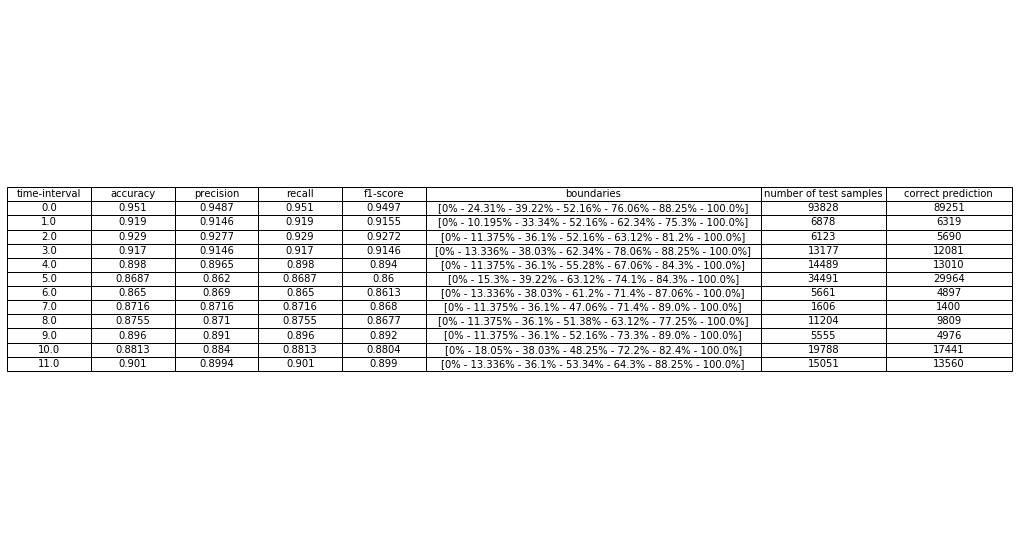

In [208]:
q = resultDataFrameNoPenalty_7Class["boundaries"].tolist()
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
print(listOfBoundaries)
numberOfTestSamples = [93828, 6878, 6123, 13177, 14489, 34491, 5661, 1606, 11204, 5555, 19788, 15051]
time = [int(i) for i in range(12)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_7Class["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_7Class["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_7Class["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_7Class["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))
x = np.vstack((x, numberOfTestSamples))
x = np.vstack((x, (resultDataFrameNoPenalty_7Class["accuracy"] * numberOfTestSamples).astype(np.int32)))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries', 
                                'number of test samples', 'correct prediction'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4, 0.15, 0.15],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,8):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,13):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-6class-lr-noPenalty-accuracy.svg", format="svg")
plt.show(the_table)

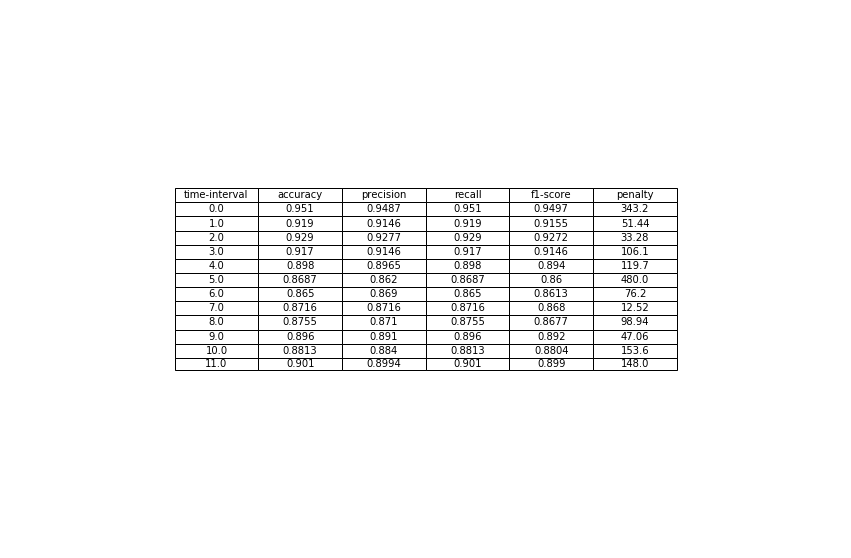

In [214]:
time = [int(i) for i in range(12)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_7Class["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_7Class["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_7Class["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_7Class["f1Score"]))
x = np.vstack((x, resultDataFrameNoPenalty_7Class["penalty"]))
x = x.astype(np.float16)

plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'penalty'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.1],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,12):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-6class-lr-noPenalty-accuracy-penaltyVal.svg", format="svg")
plt.show(the_table)

## 5 Classes

In [152]:
name = "/home/sepehr/thesis/APDataML/4normal_correlated_lumping_Boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [41]:
normalLumping[0]

[(1.0,
  42.0208740234375,
  array([[0.81138113, 0.        , 0.        , 0.        , 0.        ],
         [0.42046432, 0.25824308, 0.01817088, 0.        , 0.        ],
         [0.32307692, 0.16666667, 0.22638146, 0.00254777, 0.        ],
         [0.23076923, 0.        , 0.        , 0.15384615, 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ]]),
  [-1, 20, 35, 52, 73, 89])]

In [153]:
percentageArray = []
for i in range(12):
    name = "/home/sepehr/thesis/APDataML/pickles/4normal_correlated_lumping_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [154]:
accuracyResult = [np.inf for i in range(12)]
penaltyResult = [np.inf for i in range(12)]
precisionResult = [np.inf for i in range(12)]
recallResult = [np.inf for i in range(12)]
f1ScoreResult = [np.inf for i in range(12)]
boundariesResult = [np.inf for i in range(12)]
lumpAproxResult = [np.inf for i in range(12)]
lumpErrorResult = [np.inf for i in range(12)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}


resultDataFrameNoPenalty_6Class = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty_6Class = resultDataFrameNoPenalty.astype('object')

In [155]:
warnings.filterwarnings('ignore')
for timeIndex in range(12):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty_6Class.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 24.31372549  39.21568627  56.07843137  77.25490196 100.        ]
start training set generation
375309
93828
starting tensor
Initialized
epoch  0 0.9453338165075034 9.730177056516983
epoch  20 0.9527492965552524 7.755384297368064
epoch  40 0.9526960052864939 7.731349757269005
epoch  60 0.9526134038199181 7.725949128634851
epoch  80 0.9527226509208732 7.717371542946945
epoch  100 0.952762619372442 7.719406011312346
epoch  120 0.9528532145293315 7.721767327317517
epoch  140 0.9526933407230559 7.7133418098295365
epoch  160 0.9528318980218281 7.71278736106086


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



1
[ 10.19607843  33.33333333  54.11764706  77.25490196 100.        ]
start training set generation
27545
6887
starting tensor
Initialized
epoch  0 0.8882267441860465 20.881785605674565
epoch  20 0.9236918604651163 11.822027682149129
epoch  40 0.9246002906976745 11.639602762044866
epoch  60 0.925 11.597387340456942
epoch  80 0.924890988372093 11.551450778717214
epoch  100 0.9251453488372093 11.563354772190719
epoch  120 0.9251453488372093 11.532968717952112
epoch  140 0.9247456395348838 11.520269190433412
epoch  160 0.9259447674418605 11.468043962190322
epoch  180 0.9259447674418605 11.493627807151439
epoch  200 0.9256540697674419 11.474275214173074
epoch  220 0.9264534883720931 11.470396536172826
epoch  240 0.9259084302325581 11.457526747016015
epoch  260 0.9259447674418605 11.442613865053936
epoch  280 0.9259811046511628 11.475714742305653
epoch  300 0.9268531976744186 11.451644391791765
epoch  320 0.9257267441860465 11.456697801656505
epoch  340 0.9257994186046512 11.457724458117813


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[ 11.37254902  36.07843137  56.07843137  80.39215686 100.        ]
start training set generation
24492
6123
starting tensor
Initialized
epoch  0 0.8944698952879581 20.581085036562378
epoch  20 0.9299738219895288 11.083591777616766
epoch  40 0.9313645287958116 10.962455839386793
epoch  60 0.9312009162303665 10.917049716904527
epoch  80 0.9321007853403142 10.837619669774442
epoch  100 0.9313645287958116 10.85942359931806
epoch  120 0.9319371727748691 10.84799792722882
epoch  140 0.9324689136125655 10.80697374506146
epoch  160 0.9326734293193717 10.852809545257328
epoch  180 0.9324280104712042 10.781793880212996
epoch  200 0.9329597513089005 10.789899168214253
epoch  220 0.9319371727748691 10.770904333803662
epoch  240 0.9323462041884817 10.798218620385173
epoch  260 0.932387107329843 10.76355772804839
epoch  280 0.9321825916230366 10.814177903829444
epoch  300 0.9324280104712042 10.751374404467837
epoch  320 0.9334914921465969 10.769403730387468
epoch  340 0.9325916230366492 10.7482426

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



7
[ 23.1372549   47.05882353  71.37254902  89.01960784 100.        ]
start training set generation
6423
1606
starting tensor
Initialized
epoch  0 0.7128125 49.20833572387696
epoch  20 0.83484375 25.109564685821532
epoch  40 0.84609375 23.203124666213984
epoch  60 0.85015625 22.505582342147818
epoch  80 0.85140625 22.143062496185294
epoch  100 0.85359375 22.099576816558837
epoch  120 0.84875 22.058678150177002
epoch  140 0.85171875 21.90218077659607
epoch  160 0.85328125 21.861716651916502
epoch  180 0.85171875 21.830388746261587
epoch  200 0.85546875 21.796083946228027
epoch  220 0.85375 21.78133481979371
epoch  240 0.85453125 21.718864402771
epoch  260 0.855 21.64515930175782
epoch  280 0.85484375 21.657001895904543
epoch  300 0.8521875 21.77127857208252
epoch  320 0.85390625 21.744419660568237
8
[ 11.37254902  35.29411765  58.03921569  82.35294118 100.        ]
start training set generation
44816
11204
starting tensor
Initialized
epoch  0 0.8283705357142858 29.454401671545845
epoch  

In [209]:
resultDataFrameNoPenalty_6Class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.946551,414.336,0.949245,0.946551,0.947678,"[24.31372549019606, 39.215686274509736, 56.078...",1,42.0209
1,0.918687,59.7736,0.913825,0.918687,0.914685,"[10.196078431372554, 33.333333333333286, 54.11...",1,46.7483
2,0.933529,40.161,0.932631,0.933529,0.932083,"[11.372549019607849, 36.07843137254896, 56.078...",1,35.325
3,0.916977,129.006,0.91606,0.916977,0.914796,"[13.333333333333341, 38.039215686274446, 62.35...",1,39.6284
4,0.902754,148.75,0.90327,0.902754,0.900585,"[11.372549019607849, 36.07843137254896, 59.215...",1,41.1243
5,0.872025,535.258,0.870152,0.872025,0.868295,"[15.294117647058833, 39.215686274509736, 63.13...",0.666992,36.5415
6,0.870518,80.404,0.871869,0.870518,0.868914,"[13.333333333333341, 38.039215686274446, 60.39...",0.75,41.4802
7,0.845579,28.9323,0.851243,0.845579,0.844185,"[23.13725490196077, 47.05882352941167, 71.3725...",1,50.7913
8,0.879686,147.384,0.876923,0.879686,0.875385,"[11.372549019607849, 35.29411764705877, 58.039...",0.777832,38.2456
9,0.89847,64.1143,0.896194,0.89847,0.896,"[11.372549019607849, 36.07843137254896, 57.254...",1,46.4207


In [211]:
resultDataFrameNoPenalty_6Class.to_pickle("5class_lr_noPenalty_merged.pickle")

In [203]:
print(np.sum(resultDataFrameNoPenalty_6Class["accuracy"] * numberOfTestSamples))
print(((208438 - 207782)*100)/np.sum(numberOfTestSamples))
np.sum(numberOfTestSamples)

208438.73181356178
0.28790744828857456


227851

['[0% - 24.31% - 39.22% - 56.1% - 77.25% - 100.0%]', '[0% - 10.195% - 33.34% - 54.12% - 77.25% - 100.0%]', '[0% - 11.375% - 36.1% - 56.1% - 80.4% - 100.0%]', '[0% - 13.336% - 38.03% - 62.34% - 78.06% - 100.0%]', '[0% - 11.375% - 36.1% - 59.22% - 82.4% - 100.0%]', '[0% - 15.3% - 39.22% - 63.12% - 76.06% - 100.0%]', '[0% - 13.336% - 38.03% - 60.4% - 85.1% - 100.0%]', '[0% - 23.14% - 47.06% - 71.4% - 89.0% - 100.0%]', '[0% - 11.375% - 35.28% - 58.03% - 82.4% - 100.0%]', '[0% - 11.375% - 36.1% - 57.25% - 75.3% - 100.0%]', '[0% - 14.12% - 38.03% - 57.25% - 81.2% - 100.0%]', '[0% - 13.336% - 38.03% - 62.34% - 87.06% - 100.0%]']
0       88813
1     6318.73
2        5716
3       12083
4       13080
5       30077
6        4928
7        1358
8        9856
9        4991
10      17648
11      13570
Name: accuracy, dtype: object


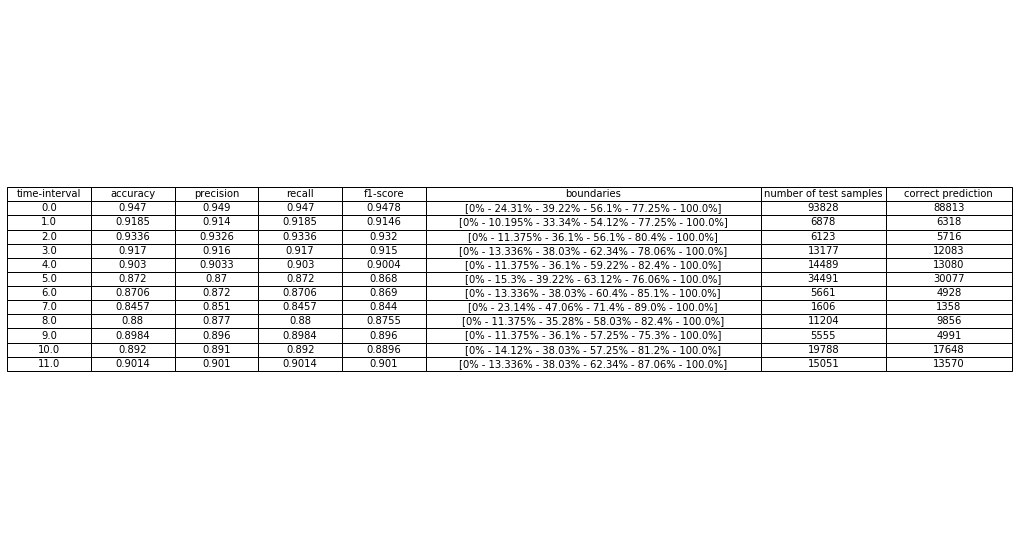

In [206]:
q = resultDataFrameNoPenalty_6Class["boundaries"].tolist()
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
print(listOfBoundaries)
time = [int(i) for i in range(12)]
numberOfTestSamples = [93828, 6878, 6123, 13177, 14489, 34491, 5661, 1606, 11204, 5555, 19788, 15051]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_6Class["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))
x = np.vstack((x, numberOfTestSamples))
x = np.vstack((x, (resultDataFrameNoPenalty_6Class["accuracy"] * numberOfTestSamples).astype(np.int32)))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries', 
                                'number of test samples', 'correct prediction'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4, 0.15, 0.15],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,8):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,13):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-5class-lr-noPenalty-accuracy.svg", format="svg")
plt.show(the_table)

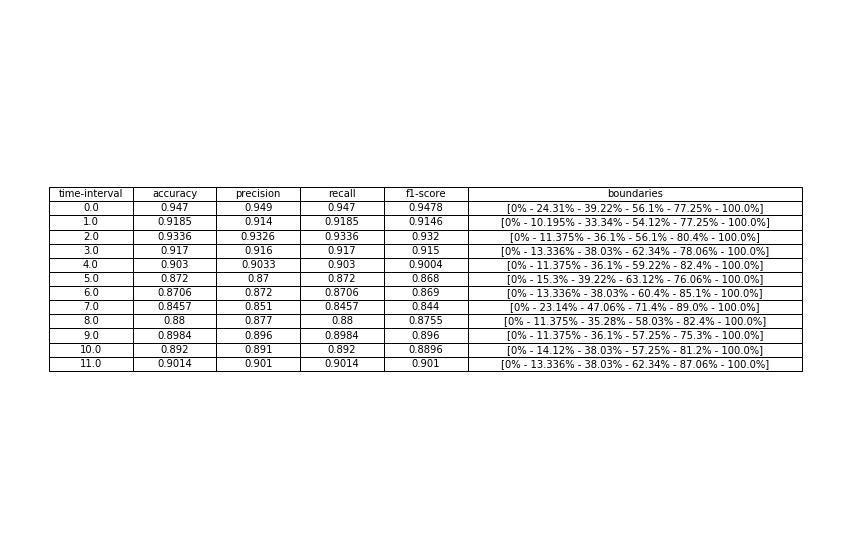

In [237]:
q = resultDataFrameNoPenalty_6Class["boundaries"].tolist()
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
time = [int(i) for i in range(12)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_6Class["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))

plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4, 0.15, 0.15],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,13):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-5class-lr-noPenalty-accuracy-Const25.svg", format="svg")
plt.show(the_table)

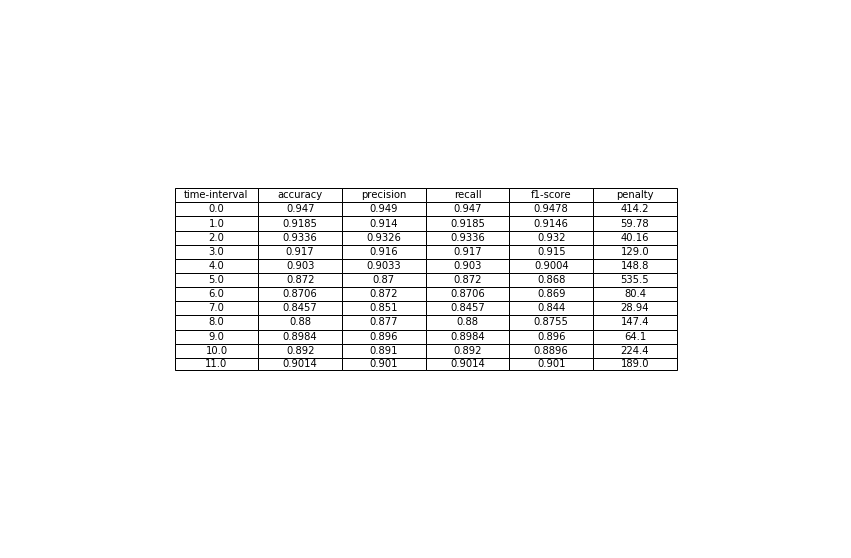

In [233]:
time = [int(i) for i in range(12)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_6Class["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["f1Score"]))
x = np.vstack((x, resultDataFrameNoPenalty_6Class["penalty"]))
x = x.astype(np.float16)

plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'penalty'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.1],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,12):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-5class-lr-noPenalty-accuracy-penaltyVal.svg", format="svg")
plt.show(the_table)

# Fetching Lumped Matrices with their Bandwidths - 15 cons

## 9 clusters

In [130]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range(12)]
for timeIndex in range(12):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_correlated_lumping_result_15Cons_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

name = "/home/sepehr/thesis/APDataML/9normal_correlated_lumping_Boundaries.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

0
1
2
3
4
5
6
7
8
9
10
11


In [156]:
name = "/home/sepehr/thesis/APDataML/9normal_correlated_lumping_Boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [157]:
percentageArray = []
for i in range(12):
    name = "/home/sepehr/thesis/APDataML/pickles/5normal_correlated_lumping_percentage_15Cons_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [158]:
accuracyResult = [np.inf for i in range(12)]
penaltyResult = [np.inf for i in range(12)]
precisionResult = [np.inf for i in range(12)]
recallResult = [np.inf for i in range(12)]
f1ScoreResult = [np.inf for i in range(12)]
boundariesResult = [np.inf for i in range(12)]
lumpAproxResult = [np.inf for i in range(12)]
lumpErrorResult = [np.inf for i in range(12)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}


resultDataFrameNoPenalty_9Class = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty_9Class = resultDataFrameNoPenalty_9Class.astype('object')

In [160]:
warnings.filterwarnings('ignore')
for timeIndex in range(12):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty_9Class.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

    

0
[ 10.19607843  25.09803922  39.21568627  51.37254902  61.17647059
  76.07843137  88.23529412 100.        ]
start training set generation
375309
93828
starting tensor
Initialized
epoch  0 0.8829297407912687 19.90281177729891
epoch  20 0.9079180167121419 14.217792469271206
epoch  40 0.9081098652796725 14.121316157657471
epoch  60 0.9084296128922238 14.074380838448153
epoch  80 0.9081551628581174 14.053952659664509
epoch  100 0.9083363531718963 14.033288806839497
epoch  120 0.9085202080491133 14.023338208785638
epoch  140 0.9089332153819918 14.00724786670439
epoch  160 0.9086614299113234 14.003140048513943
epoch  180 0.9088239682810368 13.985656006152437
epoch  200 0.9088133100272852 13.982481528840962
epoch  220 0.9087946580832197 13.977524472616537
epoch  240 0.908962525579809 13.981701919887763
epoch  260 0.9090184814120055 13.96967585923564
epoch  280 0.9088319619713506 13.968861777736901
epoch  300 0.90899982946794 13.964794964492718
epoch  320 0.909037133356071 13.96885481041743
e

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[ 10.19607843  24.31372549  36.07843137  48.23529412  61.17647059
  76.07843137  90.19607843 100.        ]
start training set generation
24492
6123
starting tensor
Initialized
epoch  0 0.6970304319371727 59.52487004864279
epoch  20 0.8619518979057592 21.27652768689299
epoch  40 0.8667375654450262 20.235244910754474
epoch  60 0.8682918848167539 19.825079251334312
epoch  80 0.8691917539267016 19.64440752448835
epoch  100 0.8708278795811518 19.480847845526878
epoch  120 0.8710323952879581 19.37119545612039
epoch  140 0.8726685209424084 19.323620633929185
epoch  160 0.8711551047120419 19.322074128695167
epoch  180 0.8724231020942408 19.233116796503513
epoch  200 0.8731593586387435 19.246819019317652
epoch  220 0.8720549738219895 19.28543094315452
epoch  240 0.8738547120418848 19.18200880070632
epoch  260 0.8718913612565445 19.181194193076074
epoch  280 0.8738547120418848 19.170137074605336
epoch  300 0.873241164921466 19.150151040541548
epoch  320 0.8731184554973822 19.167580484719803
ep

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



7
[ 12.15686275  27.05882353  41.17647059  54.11764706  69.01960784
  72.15686275  87.05882353 100.        ]
start training set generation
6423
1606
starting tensor
Initialized
epoch  0 0.4175 106.30404529571533
epoch  20 0.77375 35.977767944335945
epoch  40 0.7896875 32.047150859832755
epoch  60 0.7996875 30.114964408874513
epoch  80 0.80625 28.960498638153076
epoch  100 0.81203125 28.162452201843262
epoch  120 0.81359375 27.64777222633362
epoch  140 0.8159375 27.1997314453125
epoch  160 0.8178125 26.940154705047608
epoch  180 0.81640625 26.69329442977905
epoch  200 0.82 26.429702348709107
epoch  220 0.82140625 26.311972751617432
epoch  240 0.821875 26.27568202972412
epoch  260 0.82328125 25.993790855407713
epoch  280 0.8228125 26.021932468414306
epoch  300 0.8228125 25.85993528366089
epoch  320 0.82484375 25.81012809753418
epoch  340 0.82453125 25.7526873588562
epoch  360 0.82671875 25.671020851135253
epoch  380 0.8259375 25.54369839668275
epoch  400 0.8290625 25.491262626647945
epoc

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



8
[ 11.37254902  26.2745098   40.39215686  48.23529412  63.1372549
  77.25490196  88.23529412 100.        ]
start training set generation
44816
11204
starting tensor
Initialized
epoch  0 0.6770982142857143 59.013206141335615
epoch  20 0.8062053571428571 29.09578689847673
epoch  40 0.8107366071428571 27.922294604437692
epoch  60 0.8129464285714286 27.478151909964424
epoch  80 0.8136383928571429 27.302780096871512
epoch  100 0.814375 27.158749016353063
epoch  120 0.8163392857142857 27.07114219393049
epoch  140 0.8151339285714285 26.997375737598965
epoch  160 0.8150446428571428 26.98487571852547
epoch  180 0.8159151785714286 26.94418004308428
epoch  200 0.8156473214285714 26.900406962803423
epoch  220 0.8163169642857143 26.90527698516844
epoch  240 0.8158928571428572 26.88506020001003
epoch  260 0.8150223214285715 26.86232364654541
epoch  280 0.8167857142857143 26.868793396268583
epoch  300 0.8163616071428571 26.872951274599348
epoch  320 0.8158035714285714 26.836707570212234
epoch  340 0

In [161]:
resultDataFrameNoPenalty_9Class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.904506,300.869,0.90473,0.904506,0.903399,"[10.196078431372554, 25.098039215686253, 39.21...",1,43.1949
1,0.89197,28.4422,0.885194,0.89197,0.886888,"[10.196078431372554, 25.098039215686253, 39.21...",1,46.0969
2,0.864935,24.8326,0.863983,0.864935,0.861822,"[10.196078431372554, 24.31372549019606, 36.078...",1,40.1233
3,0.874858,62.7253,0.87256,0.874858,0.870566,"[13.333333333333341, 28.235294117647026, 43.13...",1,42.3474
4,0.828076,79.2382,0.829611,0.828076,0.822923,"[13.333333333333341, 28.235294117647026, 40.39...",0.68457,38.4677
5,0.82349,219.563,0.826291,0.82349,0.819099,"[14.117647058823538, 29.01960784313722, 43.137...",0.666504,37.9624
6,0.804805,42.6535,0.807501,0.804805,0.796478,"[8.235294117647062, 23.13725490196077, 38.0392...",0.833008,37.3296
7,0.817559,12.2857,0.818052,0.817559,0.809968,"[12.156862745098046, 27.058823529411736, 41.17...",1,51.0125
8,0.81096,77.4758,0.816336,0.81096,0.804421,"[11.372549019607849, 26.274509803921543, 40.39...",0.777832,40.4514
9,0.817282,29.3723,0.823986,0.817282,0.81401,"[11.372549019607849, 26.274509803921543, 37.25...",1,44.1387


In [212]:
resultDataFrameNoPenalty_9Class.to_pickle("8class_lr_noPenalty_merged_15.pickle")

In [162]:
for i in range(12):
    print(resultDataFrameNoPenalty_9Class["boundaries"].loc[i])

[ 10.19607843  25.09803922  39.21568627  51.37254902  61.17647059
  76.07843137  88.23529412 100.        ]
[ 10.19607843  25.09803922  39.21568627  53.33333333  63.1372549
  78.03921569  92.15686275 100.        ]
[ 10.19607843  24.31372549  36.07843137  48.23529412  61.17647059
  76.07843137  90.19607843 100.        ]
[ 13.33333333  28.23529412  43.1372549   56.07843137  68.23529412
  79.21568627  92.15686275 100.        ]
[ 13.33333333  28.23529412  40.39215686  55.29411765  70.19607843
  82.35294118  94.11764706 100.        ]
[ 14.11764706  29.01960784  43.1372549   58.03921569  70.19607843
  84.31372549  95.29411765 100.        ]
[  8.23529412  23.1372549   38.03921569  52.15686275  67.05882353
  80.39215686  88.23529412 100.        ]
[ 12.15686275  27.05882353  41.17647059  54.11764706  69.01960784
  72.15686275  87.05882353 100.        ]
[ 11.37254902  26.2745098   40.39215686  48.23529412  63.1372549
  77.25490196  88.23529412 100.        ]
[ 11.37254902  26.2745098   37.25490196

In [243]:
resultDataFrameNoPenalty_9Class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.904506,300.869,0.90473,0.904506,0.903399,"[10.196078431372554, 25.098039215686253, 39.21...",1,43.1949
1,0.89197,28.4422,0.885194,0.89197,0.886888,"[10.196078431372554, 25.098039215686253, 39.21...",1,46.0969
2,0.864935,24.8326,0.863983,0.864935,0.861822,"[10.196078431372554, 24.31372549019606, 36.078...",1,40.1233
3,0.874858,62.7253,0.87256,0.874858,0.870566,"[13.333333333333341, 28.235294117647026, 43.13...",1,42.3474
4,0.828076,79.2382,0.829611,0.828076,0.822923,"[13.333333333333341, 28.235294117647026, 40.39...",0.68457,38.4677
5,0.82349,219.563,0.826291,0.82349,0.819099,"[14.117647058823538, 29.01960784313722, 43.137...",0.666504,37.9624
6,0.804805,42.6535,0.807501,0.804805,0.796478,"[8.235294117647062, 23.13725490196077, 38.0392...",0.833008,37.3296
7,0.817559,12.2857,0.818052,0.817559,0.809968,"[12.156862745098046, 27.058823529411736, 41.17...",1,51.0125
8,0.81096,77.4758,0.816336,0.81096,0.804421,"[11.372549019607849, 26.274509803921543, 40.39...",0.777832,40.4514
9,0.817282,29.3723,0.823986,0.817282,0.81401,"[11.372549019607849, 26.274509803921543, 37.25...",1,44.1387


['[0% - 10.195% - 25.1% - 39.22% - 51.38% - 61.2% - 76.06% - 88.25% - 100.0%]', '[0% - 10.195% - 25.1% - 39.22% - 53.34% - 63.12% - 78.06% - 92.2% - 100.0%]', '[0% - 10.195% - 24.31% - 36.1% - 48.25% - 61.2% - 76.06% - 90.2% - 100.0%]', '[0% - 13.336% - 28.23% - 43.12% - 56.1% - 68.25% - 79.2% - 92.2% - 100.0%]', '[0% - 13.336% - 28.23% - 40.4% - 55.28% - 70.2% - 82.4% - 94.1% - 100.0%]', '[0% - 14.12% - 29.02% - 43.12% - 58.03% - 70.2% - 84.3% - 95.3% - 100.0%]', '[0% - 8.234% - 23.14% - 38.03% - 52.16% - 67.06% - 80.4% - 88.25% - 100.0%]', '[0% - 12.16% - 27.06% - 41.2% - 54.12% - 69.0% - 72.2% - 87.06% - 100.0%]', '[0% - 11.375% - 26.28% - 40.4% - 48.25% - 63.12% - 77.25% - 88.25% - 100.0%]', '[0% - 11.375% - 26.28% - 37.25% - 52.16% - 64.3% - 75.3% - 90.2% - 100.0%]', '[0% - 9.02% - 22.36% - 37.25% - 51.38% - 66.25% - 81.2% - 85.1% - 100.0%]', '[0% - 14.12% - 19.22% - 33.34% - 48.25% - 62.34% - 77.25% - 88.25% - 100.0%]']


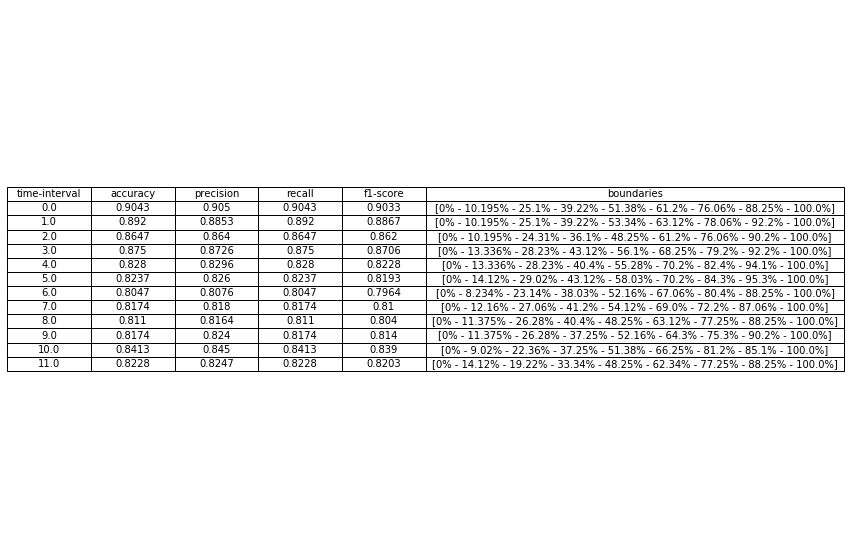

In [244]:
q = resultDataFrameNoPenalty_9Class["boundaries"].tolist()
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
print(listOfBoundaries)
time = [int(i) for i in range(12)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_9Class["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_9Class["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_9Class["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_9Class["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.5],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,13):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-8class-lr-noPenalty-accuracy-15Cons.svg", format="svg")
plt.show(the_table)

## 8 Clusters

In [139]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range(12)]
for timeIndex in range(12):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/8normal_correlated_lumping_result_15Cons_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

name = "/home/sepehr/thesis/APDataML/8normal_correlated_15Cons_lumping_Boundaries.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

0
1
2
3
4
5
6
7
8
9
10
11


In [163]:
name = "/home/sepehr/thesis/APDataML/8normal_correlated_15Cons_lumping_Boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [164]:
percentageArray = []
for i in range(12):
    name = "/home/sepehr/thesis/APDataML/pickles/8normal_correlated_lumping_percentage_15Cons_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [165]:
accuracyResult = [np.inf for i in range(12)]
penaltyResult = [np.inf for i in range(12)]
precisionResult = [np.inf for i in range(12)]
recallResult = [np.inf for i in range(12)]
f1ScoreResult = [np.inf for i in range(12)]
boundariesResult = [np.inf for i in range(12)]
lumpAproxResult = [np.inf for i in range(12)]
lumpErrorResult = [np.inf for i in range(12)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}


resultDataFrameNoPenalty_8Class = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty_8Class = resultDataFrameNoPenalty_8Class.astype('object')

In [166]:
warnings.filterwarnings('ignore')
for timeIndex in range(12):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i]
        counter = 0
        for j in range(len(percentageArray[0])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[0][j][1])
                break
    boundaries = np.append(boundaries,100)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty_8Class.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

0
start training set generation
375309
93828
starting tensor
Initialized
epoch  0 0.8829537218622101 20.177649871795598
epoch  20 0.904512704638472 14.606058713196092
epoch  40 0.9048910726466576 14.52041669728649
epoch  60 0.9052507887107776 14.479006704456312
epoch  80 0.9048590978854024 14.451539435620843
epoch  100 0.9050642692701227 14.428687411229575
epoch  120 0.9049603512960437 14.413145775643745
epoch  140 0.9052880925989086 14.406357428183492
epoch  160 0.90487508526603 14.398367976101484
epoch  180 0.9050989085948158 14.386063857179392
epoch  200 0.9048537687585266 14.38020139721211
epoch  220 0.9046619201909959 14.392964799683863
epoch  240 0.9046885658253752 14.378983618251942
epoch  260 0.904584647851296 14.374720209983328
epoch  280 0.9045979706684857 14.375096397502357
epoch  300 0.9044007929740792 14.380008701290965
epoch  320 0.9044700716234653 14.37133573875908
epoch  340 0.9046032997953616 14.376317436747145
epoch  360 0.9048830789563438 14.365351925523992
epoch  38

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



2
start training set generation
24492
6123
starting tensor
Initialized
epoch  0 0.7700425392670157 48.755258340486066
epoch  20 0.9072725785340314 14.459970702675623
epoch  40 0.9078861256544503 14.037219322164646
epoch  60 0.908949607329843 13.930169707193425
epoch  80 0.9095631544502618 13.863450236345466
epoch  100 0.9093177356020943 13.834567921323924
epoch  120 0.9087450916230366 13.824762193320309
epoch  140 0.9089087041884817 13.812999173608748
epoch  160 0.9090723167539267 13.816977322413662
epoch  180 0.910708442408377 13.754779288906077


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true samples.



3
start training set generation
52704
13177
starting tensor
Initialized
epoch  0 0.7719851154313487 43.02146934333143
epoch  20 0.8702156743620899 20.032416187253915
epoch  40 0.8706523390036452 19.698003661154576
epoch  60 0.8711269744835966 19.535149972320074
epoch  80 0.8718104495747266 19.467709529153638
epoch  100 0.8715256682867558 19.463184889727344
epoch  120 0.872645808019441 19.40018392507243
epoch  140 0.8709371202916161 19.396121195425827
epoch  160 0.8712788578371811 19.398957262931447
epoch  180 0.8721901579586877 19.358252625563846
epoch  200 0.8730445018226003 19.393151253715352
epoch  220 0.8720762454434994 19.348085446317167
epoch  240 0.8718104495747266 19.333288558922842
epoch  260 0.8721901579586877 19.35213958710108
epoch  280 0.8730445018226003 19.32545534113054
epoch  300 0.8721142162818954 19.345035935375236
epoch  320 0.8718674058323208 19.375008953877803
epoch  340 0.8716775516403402 19.332570625828936
epoch  360 0.8715256682867558 19.375603299818838
epoch  3

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



4
start training set generation
57952
14489
starting tensor
Initialized
epoch  0 0.729488950276243 47.499901913806255
epoch  20 0.8320441988950277 24.459440955272683
epoch  40 0.8344785911602209 23.91055076346213
epoch  60 0.8344440607734807 23.74519103034425
epoch  80 0.8362741712707182 23.639277950307942
epoch  100 0.8358943370165746 23.611238804179667
epoch  120 0.8368957182320442 23.564476959481414
epoch  140 0.8366885359116022 23.55263620239594
epoch  160 0.8360669889502762 23.545369703598443
epoch  180 0.8368266574585635 23.506760927063343
epoch  200 0.8363432320441989 23.51460302679579
epoch  220 0.8370511049723757 23.496838584394094
epoch  240 0.836256906077348 23.492355323496444
epoch  260 0.8362914364640884 23.493036401864565
epoch  280 0.8370338397790055 23.45909019596668
epoch  300 0.8367575966850829 23.514207810459876
epoch  320 0.8360669889502762 23.469970489206894
epoch  340 0.8378798342541437 23.47956430846156
epoch  360 0.836239640883978 23.489037084842924
epoch  380 0

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



7
start training set generation
6423
1606
starting tensor
Initialized
epoch  0 0.4053125 107.14772182464603
epoch  20 0.7678125 35.73716190338134
epoch  40 0.790625 31.503967456817627
epoch  60 0.799375 29.56429256439209
epoch  80 0.80671875 28.386399250030518
epoch  100 0.8125 27.771945762634278
epoch  120 0.81265625 27.33785726547241
epoch  140 0.81796875 26.94107986450196
epoch  160 0.81953125 26.735530109405516
epoch  180 0.819375 26.439884099960327
epoch  200 0.8196875 26.343840103149414
epoch  220 0.81953125 26.28225582122803
epoch  240 0.8253125 26.033056688308715
epoch  260 0.82359375 25.92318935394287
epoch  280 0.8240625 25.818367729187013
epoch  300 0.8246875 25.762662239074704
epoch  320 0.82515625 25.834079818725584
epoch  340 0.82328125 25.72048441886902
epoch  360 0.82609375 25.53335308074951
epoch  380 0.82671875 25.545239639282222
epoch  400 0.82390625 25.5570493888855
epoch  420 0.82671875 25.514842672348028
epoch  440 0.8246875 25.58551432609558
epoch  460 0.82578125

In [239]:
resultDataFrameNoPenalty_8Class

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.901746,285.029,0.901568,0.901746,0.900805,"[12.156862745098046, 27.058823529411736, 41.17...",1,50.0933
1,0.88471,28.955,0.880689,0.88471,0.879909,"[11.372549019607849, 26.274509803921543, 40.39...",1,51.6379
2,0.914258,31.3177,0.914738,0.914258,0.912802,"[13.333333333333341, 33.333333333333286, 53.33...",0.657227,36.5505
3,0.866282,65.2894,0.867513,0.866282,0.862731,"[11.372549019607849, 26.274509803921543, 40.39...",1,47.2173
4,0.837118,97.5449,0.835142,0.837118,0.832894,"[10.196078431372554, 25.098039215686253, 40.39...",1,45.5247
5,0.819112,284.405,0.822069,0.819112,0.814085,"[10.196078431372554, 25.098039215686253, 39.21...",0.695801,38.7236
6,0.807101,41.2311,0.810363,0.807101,0.80157,"[7.058823529411767, 22.352941176470576, 36.078...",1,43.7905
7,0.812578,10.7536,0.8233,0.812578,0.806198,"[9.019607843137258, 24.31372549019606, 38.0392...",1,55.7798
8,0.841217,83.0425,0.842661,0.841217,0.837704,"[8.235294117647062, 23.13725490196077, 38.0392...",0.799805,45.5198
9,0.824842,32.4455,0.828059,0.824842,0.820993,"[11.372549019607849, 25.098039215686253, 39.21...",1,48.0442


['[0% - 12.16% - 27.06% - 41.2% - 56.1% - 71.4% - 86.25% - 92.2% - 100.0%]', '[0% - 11.375% - 26.28% - 40.4% - 54.12% - 68.25% - 80.4% - 84.3% - 100.0%]', '[0% - 13.336% - 33.34% - 53.34% - 73.3% - 79.2% - 80.4% - 82.4% - 100.0%]', '[0% - 11.375% - 26.28% - 40.4% - 54.12% - 69.0% - 82.4% - 88.25% - 100.0%]', '[0% - 10.195% - 25.1% - 40.4% - 55.28% - 69.0% - 84.3% - 91.4% - 100.0%]', '[0% - 10.195% - 25.1% - 39.22% - 54.12% - 67.06% - 82.4% - 100.0%]', '[0% - 7.06% - 22.36% - 36.1% - 51.38% - 66.25% - 81.2% - 86.25% - 100.0%]', '[0% - 9.02% - 24.31% - 38.03% - 53.34% - 68.25% - 83.1% - 90.2% - 100.0%]', '[0% - 8.234% - 23.14% - 38.03% - 53.34% - 67.06% - 82.4% - 100.0%]', '[0% - 11.375% - 25.1% - 39.22% - 54.12% - 69.0% - 84.3% - 90.2% - 100.0%]', '[0% - 12.16% - 26.28% - 40.4% - 55.28% - 70.2% - 85.1% - 92.2% - 100.0%]', '[0% - 10.195% - 25.1% - 40.4% - 55.28% - 69.0% - 84.3% - 92.2% - 100.0%]']


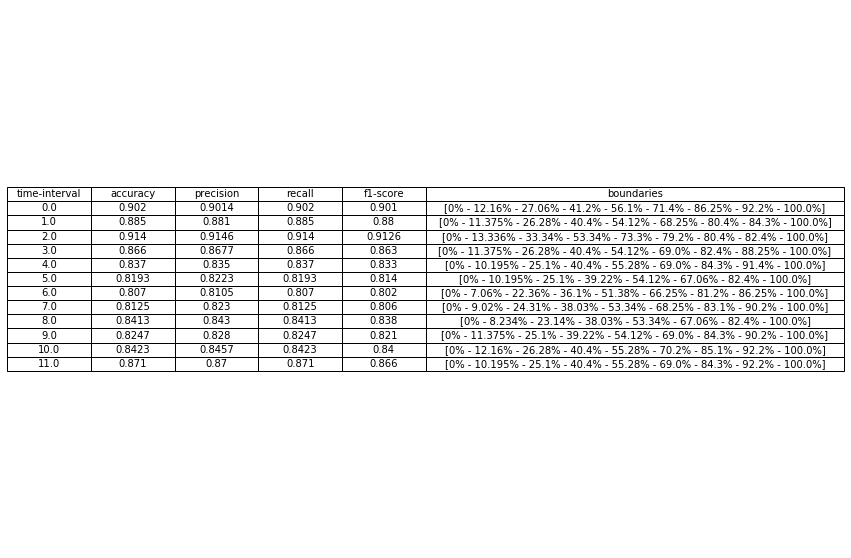

In [242]:
q = resultDataFrameNoPenalty_8Class["boundaries"].tolist()
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
print(listOfBoundaries)
time = [int(i) for i in range(12)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_8Class["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_8Class["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_8Class["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_8Class["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.5],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,13):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-8class-lr-noPenalty-accuracy-15Cons.svg", format="svg")
plt.show(the_table)

In [215]:
arrayOfLumpes = []
indexesOfCandidates = [[] for i in range(12)]
for timeIndex in range(12):
    print(timeIndex)
    name = "/home/sepehr/thesis/APDataML/pickles/8merged_lumping_35_result_" + str(timeIndex) + ".pickle"
    with open(name, 'rb') as handle:
        b = pickle.load(handle)
    
    if len(b) > 0:
        minDegree = np.inf        
        for i in range(len(b)):
            if b[i][0] < minDegree:
                minDegree = b[i][0]

        minError = np.inf
        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] < minError:
                minError = b[i][1]

        for i in range(len(b)):
            if b[i][0] == minDegree and b[i][1] == minError:
                indexesOfCandidates[timeIndex].append(b[i])

name = "/home/sepehr/thesis/APDataML/4merged_correlated_35Cons_lumping_Boundaries.pickle"
with open(name, 'wb') as handle:
    pickle.dump(indexesOfCandidates, handle) 

0
1
2
3
4
5
6
7
8
9
10
11


In [216]:
name = "/home/sepehr/thesis/APDataML/4merged_correlated_35Cons_lumping_Boundaries.pickle"
with open(name, 'rb') as handle:
    normalLumping = pickle.load(handle)

In [217]:
normalLumping[0]

[(0.8,
  39.802001953125,
  array([[0.82377049, 0.        , 0.        , 0.        , 0.        ],
         [0.31578947, 0.20833333, 0.        , 0.        , 0.        ],
         [0.33333333, 0.        , 0.07692308, 0.        , 0.        ],
         [0.        , 0.25      , 0.        , 0.        , 0.        ],
         [0.2       , 0.        , 0.        , 0.        , 0.        ]]),
  [-1, 29, 62, 73, 79, 89])]

In [219]:
percentageArray = []
for i in range(12):
    name = "/home/sepehr/thesis/APDataML/pickles/8merged_lumping_35_percentage_" + str(i) + ".pickle"
    with open(name, 'rb') as handle:
        percentageArray.append(pickle.load(handle))

In [220]:
accuracyResult = [np.inf for i in range(12)]
penaltyResult = [np.inf for i in range(12)]
precisionResult = [np.inf for i in range(12)]
recallResult = [np.inf for i in range(12)]
f1ScoreResult = [np.inf for i in range(12)]
boundariesResult = [np.inf for i in range(12)]
lumpAproxResult = [np.inf for i in range(12)]
lumpErrorResult = [np.inf for i in range(12)]


testDataFrame = {"accuracy": accuracyResult, "penalty": penaltyResult, "precision": precisionResult, 
                 "recall": recallResult, "f1Score": f1ScoreResult, "boundaries": boundariesResult, 
                 "lumpAprox": lumpAproxResult, "lumpError": lumpErrorResult}


resultDataFrameNoPenalty_5Class_35cons = pd.DataFrame(testDataFrame)
resultDataFrameNoPenalty_5Class_35cons = resultDataFrameNoPenalty_5Class_35cons.astype('object')

In [222]:
warnings.filterwarnings('ignore')
for timeIndex in range(12):
    if len(normalLumping[timeIndex]) == 0:
        continue
    
    print(timeIndex)
    boundaries = np.array([])
    for i in range(1, len(normalLumping[0][0][3])):
        bound = normalLumping[timeIndex][0][3][i] + 1
        counter = 0
        for j in range(len(percentageArray[timeIndex])):
            if percentageArray[timeIndex][j][2] == False:
                counter += 1
            if counter == bound:
                boundaries = np.append(boundaries, percentageArray[timeIndex][j][1])
                break
    boundaries = np.append(boundaries,100)
    print(boundaries)
    
    XArraysForLearning, YArraysForLearning, XArraysForTesting, YArraysForTesting, boundaries = dataPreparation(
        data, timeIndex, 30, boundaries)

    print("starting tensor")
    lossFunctionBoolean = 0
    accuracy_result, penaltyValue, precision, recall, f1Score = tensorFlowLossFunction(
        lossFunctionBoolean, XArraysForLearning, YArraysForLearning, XArraysForTesting, 
        YArraysForTesting, boundaries)
    
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["accuracy"] = accuracy_result
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["penalty"] = penaltyValue
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["precision"] = precision
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["recall"] = recall
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["f1Score"] = f1Score
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["boundaries"] = boundaries
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["lumpAprox"] = normalLumping[timeIndex][0][0]
    resultDataFrameNoPenalty_5Class_35cons.loc[timeIndex]["lumpError"] = normalLumping[timeIndex][0][1]

0
[ 33.33333333  66.2745098   77.25490196  83.1372549  100.        ]
start training set generation
375309
93828
starting tensor
Initialized
epoch  0 0.9806232946793997 3.8924223336494155
epoch  20 0.983471712994543 2.921323709886165
epoch  40 0.9835489853342428 2.9029492793470077
epoch  60 0.9834637193042292 2.891967780843611
epoch  80 0.983650238744884 2.891177510156577
epoch  100 0.9834797066848567 2.8953193016426493
epoch  120 0.9836422450545702 2.8853579325522722
epoch  140 0.9836289222373806 2.8875469653987875
epoch  160 0.9837035300136425 2.8858956588599933
epoch  180 0.9836768843792633 2.8818425029506076
epoch  200 0.9836822135061392 2.8873747902824523


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



1
[  7.05882353  40.39215686  50.19607843  71.37254902 100.        ]
start training set generation
27545
6887
starting tensor
Initialized
epoch  0 0.9637718023255814 9.958325275432236
epoch  20 0.9701671511627907 5.498982493544729
epoch  40 0.9702761627906977 5.4159512012503885
epoch  60 0.970094476744186 5.373648759930631
epoch  80 0.9707122093023256 5.374482689000838
epoch  100 0.969985465116279 5.339047197131222
epoch  120 0.9705668604651163 5.335036037411799
epoch  140 0.9708575581395349 5.3388827689165295
epoch  160 0.9706395348837209 5.318301945647533
epoch  180 0.9706758720930233 5.314623369553755
epoch  200 0.9713299418604651 5.295203050485874
epoch  220 0.9708212209302326 5.295236855052234
epoch  240 0.9707848837209302 5.279077339865442
epoch  260 0.9710392441860465 5.29943920526394
epoch  280 0.9709302325581395 5.281865508473197
epoch  300 0.9711119186046512 5.288810497106503
epoch  320 0.9711845930232558 5.292116041100298
epoch  340 0.9712209302325582 5.291797353084698
epoch

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



2
[ 34.11764706  56.07843137  81.17647059  83.1372549  100.        ]
start training set generation
24492
6123
starting tensor
Initialized
epoch  0 0.9060045811518325 17.158967342052165
epoch  20 0.9561109293193717 6.567542484605499
epoch  40 0.9576652486910995 6.448654180421881
epoch  60 0.9586878272251309 6.409066273435875
epoch  80 0.959178664921466 6.359610868998223
epoch  100 0.9586469240837696 6.349336565477061
epoch  120 0.9583606020942408 6.370149486039948
epoch  140 0.9586878272251309 6.331243197487287
epoch  160 0.9581969895287958 6.381190552683399
epoch  180 0.9585651178010471 6.323815834147767
epoch  200 0.9581560863874345 6.32910136277763
epoch  220 0.9589332460732984 6.352082646017924
epoch  240 0.958851439790576 6.357375365277236
epoch  260 0.959178664921466 6.336234064314378
epoch  280 0.9587287303664922 6.345966536337168
3
[ 34.11764706  51.37254902  84.31372549  92.15686275 100.        ]


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



start training set generation
52704
13177
starting tensor
Initialized
epoch  0 0.9145086573511543 15.207105270133148
epoch  20 0.9469357533414338 8.162967693617384
epoch  40 0.94697372417983 8.146967939154356
epoch  60 0.9467458991494532 8.118179995408177
epoch  80 0.9470876366950183 8.141223530288457
epoch  100 0.9467458991494532 8.114402864567412
epoch  120 0.9467838699878494 8.128036204548977
epoch  140 0.9465180741190765 8.112393931224315
epoch  160 0.9469547387606319 8.121262378058221
epoch  180 0.9475812575941677 8.122660361402387
epoch  200 0.9472205346294046 8.110345943368088
epoch  220 0.9469547387606319 8.103745510048013
epoch  240 0.9475053159173754 8.09892823629507
epoch  260 0.9468408262454435 8.09964194390493
4
[ 28.23529412  63.1372549   85.09803922  94.11764706 100.        ]
start training set generation
57952
14489
starting tensor
Initialized
epoch  0 0.8532458563535912 22.813835018642706
epoch  20 0.891246546961326 15.808416585764174
epoch  40 0.8917299723756906 15.74

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



7
[ 13.33333333  47.05882353  71.37254902  93.33333333 100.        ]
start training set generation
6423
1606
starting tensor
Initialized
epoch  0 0.87390625 26.15030473709107
epoch  20 0.9271875 12.43942775249481
epoch  40 0.92953125 11.528946938514705
epoch  60 0.93296875 11.212638540267944
epoch  80 0.933125 11.074157629013065
epoch  100 0.93484375 10.925987218618394
epoch  120 0.934375 10.858367819786068
epoch  140 0.9353125 10.873996586799622
epoch  160 0.9365625 10.852850666046146
epoch  180 0.9359375 10.793637802600855
epoch  200 0.93640625 10.848216781616204
epoch  220 0.9353125 10.842944514751439
epoch  240 0.93625 10.831461427211764
8
[ 34.11764706  68.23529412  95.29411765  96.07843137 100.        ]
start training set generation


/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/sepehr/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



44816
11204
starting tensor
Initialized
epoch  0 0.8683035714285714 21.051694726943975
epoch  20 0.9121875 12.860446840013768
epoch  40 0.9135267857142857 12.792306306702766
epoch  60 0.9120758928571429 12.80528535297939
epoch  80 0.9135044642857143 12.753931613649637
epoch  100 0.913125 12.747480748040335
epoch  120 0.9127455357142857 12.735308845043177
epoch  140 0.9128125 12.743748008183076
epoch  160 0.9136830357142857 12.745080828326088
epoch  180 0.9132589285714285 12.73996715750012
epoch  200 0.91390625 12.729050171715873
epoch  220 0.9127455357142857 12.728392100334167
epoch  240 0.9137723214285715 12.70405702148165
epoch  260 0.9132366071428571 12.713075940608974
epoch  280 0.9133035714285714 12.727044296605246
epoch  300 0.9133928571428571 12.72921224049159
epoch  320 0.9139285714285714 12.689927767685491
epoch  340 0.914375 12.707518709046507
epoch  360 0.9139955357142857 12.699191925185056
epoch  380 0.9136160714285714 12.685943072863981
epoch  400 0.9140401785714286 12.651

In [223]:
resultDataFrameNoPenalty_5Class_35cons

,accuracy,penalty,precision,recall,f1Score,boundaries,lumpAprox,lumpError
0,0.981168,667.816,0.981811,0.981168,0.981453,"[33.333333333333286, 66.2745098039214, 77.2549...",0.799805,39.802
1,0.96733,18.6125,0.95922,0.96733,0.961361,"[7.058823529411767, 40.392156862745026, 50.196...",1,36.6039
2,0.957047,51.9316,0.958075,0.957047,0.957523,"[34.11764705882348, 56.07843137254889, 81.1764...",0.574219,32.5596
3,0.950292,105.084,0.946481,0.950292,0.947718,"[34.11764705882348, 51.37254901960773, 84.3137...",0.783203,41.783
4,0.885085,507.663,0.887929,0.885085,0.886202,"[28.235294117647026, 63.13725490196063, 85.098...",0.646484,37.2031
5,0.933664,342.033,0.931662,0.933664,0.931335,"[10.196078431372554, 45.098039215686185, 75.29...",0.509277,33.2728
6,0.907084,77.0193,0.899711,0.907084,0.901242,"[8.235294117647062, 15.294117647058833, 50.196...",0.551758,33.5997
7,0.937111,13.9925,0.936885,0.937111,0.936591,"[13.333333333333341, 47.05882352941167, 71.372...",1,43.533
8,0.900482,290.678,0.909505,0.900482,0.903338,"[34.11764705882348, 68.23529411764689, 95.2941...",0.641113,37.5444
9,0.921332,153.915,0.920622,0.921332,0.920914,"[31.3725490196078, 65.09803921568611, 91.37254...",0.875,43.916


['[0% - 33.34% - 66.25% - 77.25% - 83.1% - 100.0%]', '[0% - 7.06% - 40.4% - 50.2% - 71.4% - 100.0%]', '[0% - 34.12% - 56.1% - 81.2% - 83.1% - 100.0%]', '[0% - 34.12% - 51.38% - 84.3% - 92.2% - 100.0%]', '[0% - 28.23% - 63.12% - 85.1% - 94.1% - 100.0%]', '[0% - 10.195% - 45.1% - 75.3% - 94.1% - 100.0%]', '[0% - 8.234% - 15.3% - 50.2% - 84.3% - 100.0%]', '[0% - 13.336% - 47.06% - 71.4% - 93.3% - 100.0%]', '[0% - 34.12% - 68.25% - 95.3% - 96.06% - 100.0%]', '[0% - 31.38% - 65.1% - 91.4% - 92.2% - 100.0%]', '[0% - 7.06% - 41.2% - 76.06% - 82.4% - 100.0%]', '[0% - 7.06% - 40.4% - 68.25% - 88.25% - 100.0%]']


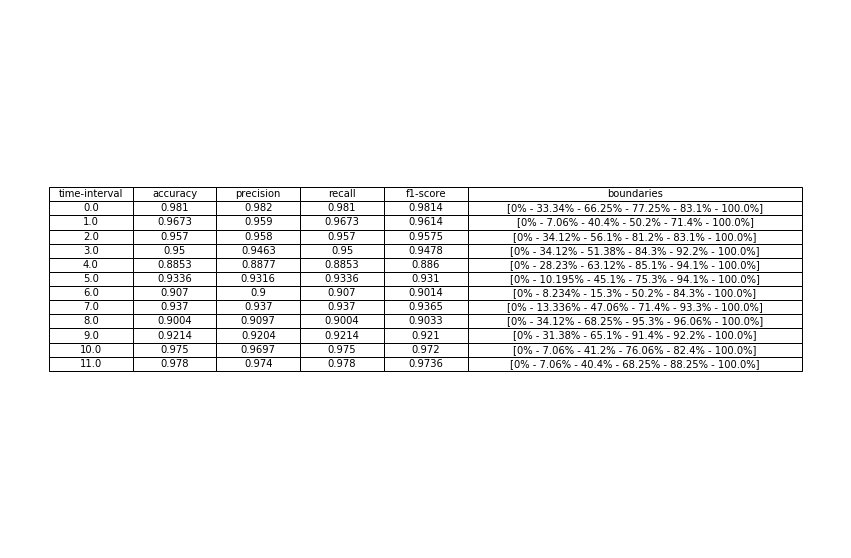

In [238]:
q = resultDataFrameNoPenalty_5Class_35cons["boundaries"].tolist()
listOfBoundaries = []
for i in range(len(q)):
    string = "[0% - "
    for j in range(len(q[i]) - 1):
        string += str(q[i][j].astype(np.float16))
        string += "% - "
    string += "100.0%]"
    listOfBoundaries.append(string)
    
print(listOfBoundaries)
time = [int(i) for i in range(12)]
x = np.array([])
x = np.append(x, time)
x = np.vstack((x, resultDataFrameNoPenalty_5Class_35cons["accuracy"]))
x = np.vstack((x, resultDataFrameNoPenalty_5Class_35cons["precision"]))
x = np.vstack((x, resultDataFrameNoPenalty_5Class_35cons["recall"]))
x = np.vstack((x, resultDataFrameNoPenalty_5Class_35cons["f1Score"]))
x = x.astype(np.float16)
x = np.vstack((x, listOfBoundaries))


plt.figure(figsize=(15,10))
# fig, ax = plt.subplots()
plt.axis('off')
plt.axis('tight')
the_table = plt.table(cellText=x.T,
#                       rowLabels=rows,
                      colLabels=['time-interval','accuracy', 'precision', 'recall', 'f1-score', 'boundaries'],
                      colWidths=[0.1,0.1,0.1,0.1, 0.1, 0.4],
                      cellLoc='center',
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
cellDict = the_table.get_celld()
for i in range(0,6):
    cellDict[(0,i)].set_height(0.026)
    for j in range(1,13):
        cellDict[(j,i)].set_height(0.026)
plt.savefig("5min-5class-lr-noPenalty-accuracy-35Cons.svg", format="svg")
plt.show(the_table)